# Breadth First Search

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/bfs.ipynb)

In the previous notebook, we constructed an Erdos-Renyi graph and wrote a version of depth-first search (DFS) that works for graphs.

When we did DFS in a tree, there was only one path from the root to any other node, so we never discovered the same node twice.
In a graph, there might be multiple paths to the same node.
To avoid discovering the same node over and over, we have to keep track of the nodes we've seen.

In this notebook, we'll adapt the level-order traversal in the same way; the result is a breadth-first search (BFS).
Then we'll adapt BFS to implement Dijkstra's algorithm, which computes the shortest path from a starting node to every other node (provided it is reachable).

We'll test these functions with a Watts-Strogatz graph, then replicate part of an experiment from a [well-known paper](https://github.com/AllenDowney/ThinkComplexity2/blob/master/papers/watts98collective.pdf).

## Watts-Strogatz graphs

A Watts-Strogatz (WS) graph is a random graph, like an Erdos-Renyi graph, but the construction process is different.
A WS graph starts with a ring lattice and randomly "rewires" some of the edges.

NetworkX provides [a function that makes a WS graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html), so we can see what it looks like.

Here's an example with `n=10` nodes, each connected to `k=2` neighbors, with probability `p=0` of rewiring each edge.

In [10]:
import networkx as nx

G = nx.watts_strogatz_graph(n=10, k=5, p=0.4)
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

The result is a ring where each node holds hands with its immediate neighbors.

In [5]:
def draw_graph(G):
    nx.draw_circular(G, node_size=1000, with_labels=True)

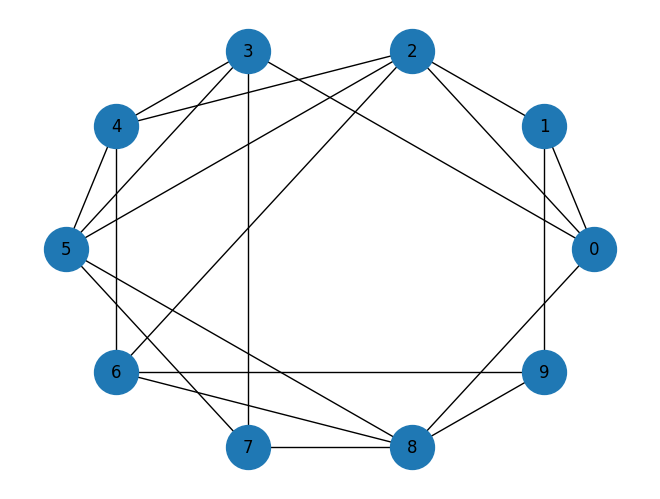

In [11]:
draw_graph(G)

**Exercise:** Run this code again with different values of `k` and `p` to see what the effect is.

Note: If `k` is odd, it gets "rounded down" to an even number.

## Breadth-first search

Here's the function from the previous notebook that implements depth-first search in a graph.

In [13]:
def reachable_nodes(G, start):
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(G[node])
    return seen

In [14]:
reachable_nodes(G, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

**Exercise:** Make a version of this function called `reachable_nodes_bfs` that does the same thing using breadth-first search.

In [15]:
from collections import deque
def reachable_nodes_bfs(G, start):
    seen = set()
    deq = deque([start])
    while deq:
      node = deq.popleft()
      if node not in seen:
        seen.add(node)
        deq.extend(G[node])
    return seen

You can use this example to test your code.

In [16]:
reachable_nodes_bfs(G, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Fast BFS

NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).
Here is a version I modified to return a set of nodes:

In [18]:
def plain_bfs(G, start):
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Let's compare this function to `reachable_nodes_bfs` and see which is faster.

In [19]:
G = nx.watts_strogatz_graph(1000, 10, 0.01)

In [20]:
%timeit reachable_nodes_bfs(G, 0)

1.49 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
%timeit plain_bfs(G, 0)

1.23 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Dijkstra's algorithm

During a breadth-first search, whenever we discover a new node, the path we took must be the shortest.
That's necessarily true because, if there had been a shorter path, we would have discovered the node sooner.

This insight is the basis of Dijkstra's algorithm, which computes the shortest path from a give "source" node to all other (reachable) nodes.

The general version of Dijkstra's algorithm works on graphs where the edges have different lengths, like the distance between cities, for example.

We'll start with a simpler version where all edges have length `1`.
This version is similar to BFS, with one change: instead of keeping a set of nodes that have already been seen, we keep a dictionary that maps from each discovered node to its distance from the source.

**Exercise:** Write a version of `reachable_nodes_bfs` called `shortest_path_dijkstra`. It should take a graph and a source node as parameters and return a dictionary that maps from each reachable node to its distance from the source.

Hint: Start with a dictionary that maps from the source node to distance `0`.

In [28]:
def shortest_path_dijkstra(graph, start):
  distances = {start: 0}
  q = deque([start])
  while q:
    node = q.popleft()
    for neighbor in graph[node]:
      if neighbor not in distances:
        distances[neighbor] = distances[node] + 1
        q.append(neighbor)
  return distances

We'll test it on a ring lattice.

In [23]:
G = nx.watts_strogatz_graph(10, 4, 0)

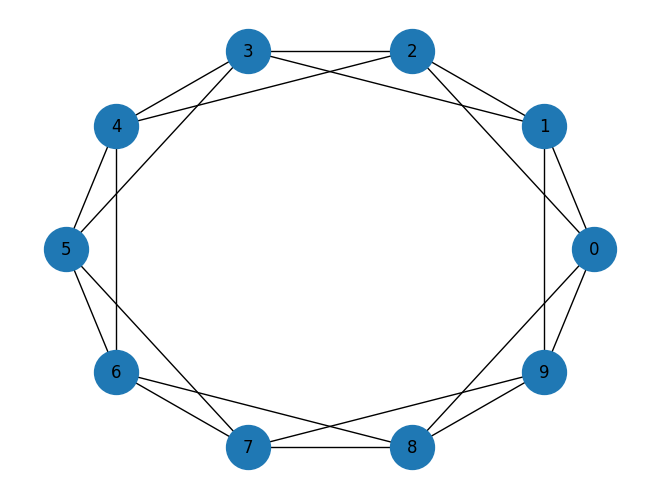

In [24]:
draw_graph(G)

In [29]:
shortest_path_dijkstra(G, 0)

{0: 0, 1: 1, 9: 1, 2: 1, 8: 1, 3: 2, 7: 2, 4: 2, 6: 2, 5: 3}

**Exercise:** Starting with `plain_bfs` write a (possibly faster) implementation of Dijkstra's algorithm that returns a dictionary that maps from each reachable node to its distance from a given source node.

You can use the following example to test it.

In [ ]:
G = nx.watts_strogatz_graph(1000, 10, 0)
d1 = shortest_path_dijkstra(G, 0)
d2 = plain_shortest_path(G, 0)
d1 == d2

And let's see which version is faster.

In [ ]:
%timeit shortest_path_dijkstra(G, 0)

In [ ]:
%timeit plain_shortest_path(G, 0)

We can also compare it to the NetworkX function that does the same thing.

In [ ]:
%timeit nx.shortest_path_length(G, 0)

## The WS Experiment

The original purpose of the Watts-Strogatz graph is to explore the structure of social networks, particularly the "small world" phenomenon, also known as "six degrees of separation".

The observation is that path lengths in social networks are shorter than you might expect: the distance between any two people on earth might be six connections (or less) on average.

The random edges in a WS graph often connect people in parts of the graph that would otherwise be far apart. Even a small number of these "long links" can greatly reduce the average path length.

To replicate part of their original experiment, I'll use `nx.average_shortest_path_length`, which takes a graph, uses the unweighted version of Dijkstra's algorithm to compute the shortest path from each node to all of the others, and returns the average of the shortest path lengths.

In [30]:
G = nx.watts_strogatz_graph(10, 4, 0)
nx.average_shortest_path_length(G)

1.6666666666666667

In [31]:
G = nx.watts_strogatz_graph(1000, 10, 0)
nx.average_shortest_path_length(G)

50.450450450450454

We'll run this function for WS graphs with a range of values for `p`.

In [32]:
import numpy as np

ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


In [33]:
lengths = []

n = 1000
k = 10
for p in ps:
    print(p)
    G = nx.watts_strogatz_graph(n, k, p)
    aspl = nx.average_shortest_path_length(G)
    lengths.append(aspl)

0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0


Here's what the result looks like.

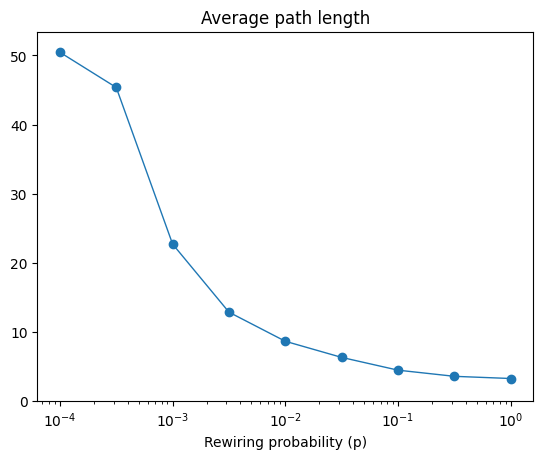

In [34]:
import matplotlib.pyplot as plt

plt.plot(ps, lengths, 'o-', linewidth=1, label='L(p)')
plt.xlabel('Rewiring probability (p)')
plt.xscale('log')
plt.ylim([0, max(lengths)+3])
plt.title('Average path length');

With `p=0.01`, we're only rewiring 1% of the edges, but the average path length is already down about as low as it will go.

*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)